## 001_CWRK: Dissertation

### Introduction
#### This Jupyter notebook focuses on fact-checking of public health claims using three different models:
1. Naive Bayes
2. BERT (Bidirectional Encoder Representations from Transformers)
3. Llama2 

The notebook demonstrates the process of data preprocessing, model training, and evaluation
for each of these approaches. By comparing these models, we aim to explore their effectiveness
in distinguishing between true and false health-related claims, which is crucial for combating
misinformation in the public health domain.


### Timeline
The disseration has to be submitted by 2pm Monday 19th August 2024

### Submitted by
**Name**: Tanuj Bhuvanesh Shriyan\
**Student Number**: 202344166\
**User ID**: 862389

## Code Cells

The code cells in this notebook demonstrate various functionalities such as data manipulation, data visualization, text preprocessing, sentiment analysis, classification, and model training. The cells are organized in a sequential manner, and each cell serves a specific purpose.

## Markdown Cells

Markdown cells are used to provide documentation and describe the workflow of the notebook. They allow for easy formatting and provide a way to explain the code and its purpose. Markdown cells can contain headings, lists, images, links, and other formatting options to enhance readability and understanding.

## Workflow

The workflow of this notebook is as follows:

1. Importing necessary libraries and modules.
2. Loading and preprocessing the data.
3. Exploratory data analysis and visualization.
4. Text preprocessing and sentiment analysis.
5. Classification using Naive Bayes classifier.
6. Training and evaluating a BERT model.
7. Prompt Engineering of Llama2 Model
8. Markdown cells for documentation and explanation.

By following this workflow, the notebook provides a comprehensive example of how to work with data, perform analysis, and build models using Jupyter Notebook.


### Library used for formatting
- Black
    - [Black Library](https://pypi.org/project/black/) - `pip install black`

In [ ]:
!pip install seaborn numpy pandas scikit-learn datasets nltk plotly torch vaderSentiment transformers wordcloud bitsandbytes accelerate
!pip install rouge_score bert_score evaluate

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk import ngrams
import torch
from huggingface_hub import login
import transformers, csv
import os
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    AutoTokenizer,
    AutoModelForCausalLM,
)
from evaluate import load
from nltk.translate.bleu_score import sentence_bleu

nltk.download("punkt")
nltk.download("stopwords")
import plotly.express as px
import plotly.graph_objects as go

# Import the SentimentIntensityAnalyzer class from the vaderSentiment module
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download the vader_lexicon for sentiment analysis
nltk.download("vader_lexicon")

# Mount Google Drive if running on Google Colab
if "COLAB_GPU" in os.environ:
    from google.colab import drive, userdata

    drive.mount("/content/drive")
    DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Data"
    userdata.get("HF_TOKEN")
else:
    DATA_DIR = "./Data"
    HF_TOKEN = os.environ.get('HF_TOKEN')

# Login to the Hugging Face Hub
login(token=HF_TOKEN)

# Define file paths
TRAIN_DS = f"{DATA_DIR}/train.tsv"
EVAL_DS = f"{DATA_DIR}/test.tsv"
NRC_LEXICON = f"{DATA_DIR}/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

2024-08-13 11:43:27.662164: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 11:43:27.732362: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 11:43:27.732399: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 11:43:27.732450: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 11:43:27.750239: I tensorflow/core/platform/cpu_feature_g

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/862389/.cache/huggingface/token
Login successful


In [3]:
def get_train_data():
    # Read the training data from the specified file path
    df = pd.read_csv(TRAIN_DS, sep="\t")
    return df


def get_eval_data():
    # Read the evaluation data from the specified file path
    df = pd.read_csv(EVAL_DS, sep="\t")
    return df


def data_preprocess(data):
    # Drop rows with missing values in the 'claim' column
    data.dropna(subset=["claim"], inplace=True)

    # Fill missing values in the 'date_published' column with 'unknown'
    data["date_published"].fillna("unknown", inplace=True)

    # Fill remaining missing values with 'N/A'
    data.fillna("N/A", inplace=True)

    # Convert 'date_published' column to datetime format
    data["date_published"] = pd.to_datetime(data["date_published"], errors="coerce")

    # Extract year and month from 'date_published' column
    data["year"] = data["date_published"].dt.year.fillna(0).astype(int)
    data["month"] = data["date_published"].dt.month.fillna(0).astype(int)

    # Replace label values with binary values (1 for 'true', 0 for 'false')
    data["label"] = data["label"].replace(
        ["false", "mixture", "unproven", "N/A", "snopes"], "false"
    )
    data["label"] = data["label"].apply(lambda x: 1 if x == "true" else 0)

    return data

In [4]:
# Get the training data
df = get_train_data()

# Display the dataframe
df

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,false,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,mixture,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,mixture,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,true,
...,...,...,...,...,...,...,...,...,...
9827,35948,The Sturgis motorcycle rally in 2020 resulted ...,"September 10, 2020","They want to know if mass-events (protests, co...",Dan Evon,"In September 2020, social media was abuzz over...",,unproven,"Politics Medical, COVID-19"
9828,401,AstraZeneca's infant respiratory drug prioriti...,"September 25, 1995",Britain’s AstraZeneca said a potential medicin...,,The “Breakthrough Therapy” and “Prime” designa...,,true,Health News
9829,2023,Testicular cancer deaths double with after 40 ...,"February 10, 2011",Men diagnosed with testicular cancer at 40 yea...,,This was true even when initial treatment and ...,http://bit.ly/fGNEw9,true,Health News
9830,38118,The FDA published “conclusive proof” that the...,"November 22, 2017",FDA Confirms DTaP Vaccine Causes Autism in Nov...,Rich Buhler & Staff,The FDA hasn’t confirmed a link between DTaP v...,https://www.truthorfiction.com/marshall-kamena...,false,Medical


## Data Analysis


## Explore Visualisations techniques

## Function Descriptions

### clean_text(text: str)

Purpose: Clean and preprocess the input text.

Key Steps:
- Converts text to lowercase.
- Removes numbers and punctuation.
- Reduces multiple spaces to a single one.
- Returns cleaned text.

### merge_classes(df)

Purpose: Merge certain classes in a DataFrame's 'label' column.

Key Steps:
- Replaces 'mixture', 'unproven', and 'snopes' with 'false'.

### data_vis(df: pd.DataFrame, column: str)

Purpose: Visualize text data from a DataFrame column using a word cloud.

Key Steps:
- Cleans the text in the specified column.
- Removes stopwords.
- Creates and displays a word cloud of the most frequent words.

### create_tokens(data)

Purpose: Tokenize the 'claim' column in a DataFrame.

Key Steps:
- Converts claims to lowercase.
- Tokenizes and removes stopwords.
- Adds a 'tokens' column to the DataFrame.

### create_unigrams(data)

Purpose: Generate unigrams (1-grams) and compute their frequency.

Key Steps:
- Tokenizes the text.
- Extracts unigrams and calculates their frequency.
- Returns a DataFrame with unigrams and their frequencies.

### create_bigrams(data)

Purpose: Generate bigrams (2-grams) and compute their frequency.

Key Steps:
- Tokenizes the text.
- Extracts bigrams and calculates their frequency.
- Returns a DataFrame with bigrams and their frequencies.

### visualise_ngram(df, target)

Purpose: Visualize the top 10 most frequent ngrams using Seaborn barplot.

Key Steps:
- Plots the top 10 ngrams with their frequencies.

### ploty_ngram(df, target)

Purpose: Visualize the top 20 most frequent ngrams using Plotly.

Key Steps:
- Plots a horizontal bar chart using Plotly for the top 20 ngrams.

### ploty_treemap(data, target)

Purpose: Visualize the top 20 bigrams as a treemap using Plotly.

Key Steps:
- Creates a treemap showing the hierarchical relationships between bigrams.

### nrc_emotion_graph(df, target)

Purpose: Display emotion scores using NRC Lexicon as a bar chart.

Key Steps:
- Aggregates emotion scores.
- Visualizes them in a bar chart.

### count_plot(df, column, title)

Purpose: Generate a count plot for a given column.

Key Steps:
- Plots the frequency of each category in the column.

In [6]:
# Copy the DataFrame
df_vis = get_train_data()
df_vis = data_preprocess(df_vis)
# We copy the dataframe to avoid altering the main dataframe.

In [42]:
def clean_text(text: str):
    """
    Cleans the given text by converting it to lowercase, removing numbers and punctuation, and reducing multiple spaces to a single space.

    Args:
      text (str): The text to be cleaned.

    Returns:
      str: The cleaned text.
    """
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text


def merge_classes(df):
    """
    Merge classes in the given DataFrame.

    Parameters:
    - df: pandas DataFrame
      The DataFrame containing the 'label' column to be merged.

    Returns:
    - df: pandas DataFrame
      The DataFrame with merged classes in the 'label' column.
    """

    merge_mapping = {"mixture": "false", "unproven": "false", "snopes": "false"}
    df["label"] = df["label"].replace

    return df


def data_vis(df: pd.DataFrame, column: str):
    """
    Visualizes the text data in a DataFrame column using a word cloud.

    Args:
      df (pd.DataFrame): The DataFrame containing the text data.
      column (str): The name of the column containing the text data.

    Returns:
      None
    """
    df.dropna(subset=[column], inplace=True)
    # Apply the cleaning text method
    df[column] = df[column].apply(clean_text)
    # Print the count for each word
    # Note: Remove the stop words
    stop_words = stopwords.words("english")
    new_stopwords = [
        "the",
        "to",
        "a",
        "in",
        "of",
        "for",
        "and",
        "that",
        "on",
        "is",
        "with",
        "new",
        "say",
        "u",
        "us",
        "says",
    ]
    stop_words.extend(new_stopwords)
    stop_words = set(stop_words)
    # Join all text together and convert it to str
    text = " ".join(word for word in df[column].astype(str) if word not in stop_words)
    print(text)

    # Note: Update Stopwords
    # Set the Stopwords

    # Create the wordcloud object
    wordcloud = WordCloud(
        width=1600,
        height=800,
        background_color="white",
        max_words=100,
        colormap="viridis",
        stopwords=stop_words,
    ).generate(text)
    # Display the Plot
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


def create_tokens(data):
    """
    Tokenizes the claims in the given data.

    Parameters:
    - data: A pandas DataFrame containing the claims.

    Returns:
    - data: The modified DataFrame with an additional 'tokens' column containing the tokenized claims.
    """
    data["tokens"] = data["claim"].apply(
        lambda x: [word for word in word_tokenize(x.lower()) if word not in STOPWORDS]
    )
    return data


def create_unigrams(data):
    """
    Create unigrams from the given data.

    Parameters:
    - data: The input data.

    Returns:
    - unigram_freq_df: DataFrame containing the unigrams and their frequencies.
    """
    data = create_tokens(data)
    data["unigrams"] = data["tokens"].apply(lambda x: list(ngrams(x, 1)))
    all_unigrams = [unigram for sublist in data["unigrams"] for unigram in sublist]
    unigram_freq = Counter(all_unigrams)
    unigram_freq_df = pd.DataFrame(
        unigram_freq.items(), columns=["unigram", "Frequency"]
    ).sort_values(by="Frequency", ascending=False)
    unigram_freq_df["unigram"] = unigram_freq_df["unigram"].apply(
        lambda x: " ".join(x) if isinstance(x, tuple) else x
    )
    return unigram_freq_df


def create_bigrams(data):
    """
    Create bigrams from the given data.

    Parameters:
    - data: The input data.

    Returns:
    - bigram_freq_df: DataFrame containing the bigrams and their frequencies, sorted in descending order of frequency.
    """
    data = create_tokens(data)
    data["bigrams"] = data["tokens"].apply(lambda x: list(ngrams(x, 2)))
    all_bigrams = [bigram for sublist in data["bigrams"] for bigram in sublist]
    bigram_freq = Counter(all_bigrams)
    bigram_freq_df = pd.DataFrame(
        bigram_freq.items(), columns=["Bigram", "Frequency"]
    ).sort_values(by="Frequency", ascending=False)
    bigram_freq_df["Bigram"] = bigram_freq_df["Bigram"].apply(
        lambda x: " ".join(x) if isinstance(x, tuple) else x
    )
    return bigram_freq_df


def visualise_ngram(df, target):
    """
    Visualizes the top 10 most frequent ngrams.

    Parameters:
    - df: DataFrame
      The DataFrame containing the ngrams and their frequencies.
    - target: str
      The target column to be plotted on the y-axis.

    Returns:
    None
    """
    plt.figure(figsize=(15, 10))
    sns.barplot(x="Frequency", y=target, data=df.head(10), palette="viridis")
    plt.title("Top 10 Most Frequent ngrams")
    plt.xlabel("Frequency")
    plt.ylabel(target)
    plt.show()


def ploty_ngram(df, target):
    """
    Plots a bar chart of the top 20 most frequent ngrams.

    Parameters:
    - df: DataFrame - The input DataFrame containing the ngram data.
    - target: str - The column name representing the ngrams.

    Returns:
    None
    """
    fig = px.bar(
        df.head(20),
        x="Frequency",
        y=target,
        orientation="h",
        template="plotly_white",
        labels={"Frequency": "Frequency", target: target},
        color_discrete_sequence=px.colors.qualitative.Safe,
    )

    fig.update_layout(
        font=dict(size=16, color="DarkSlateGray"),
        width=1600,
        height=900,
        title="Top 20 Most Frequent ngrams",
    )

    fig.show()


def ploty_treemap(data, target):
    """
    Generates a treemap plot using Plotly library.

    Parameters:
    - data: pandas DataFrame
      The input data containing the columns 'Word1', 'Word2', and 'Frequency'.
    - target: str
      The target variable for which the treemap is generated.

    Returns:
    None
    """
    data = data.iloc[:20]
    data[["Word1", "Word2"]] = data[target].str.split(expand=True)
    treemap_df = data[["Word1", "Word2", "Frequency"]]
    fig = px.treemap(
        treemap_df,
        path=["Word1", "Word2"],
        values="Frequency",
        color="Frequency",
        color_continuous_scale=px.colors.sequential.GnBu,
        title=f"Treemap of Top 20 Most Frequent {target}",
    )

    fig.update_layout(font=dict(size=18, color="DarkSlateGray"), width=1600, height=800)

    fig.show()


def nrc_emotion_graph(df, target):
    """
    Generate a bar graph of emotion scores from the NRC Lexicon.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - target (str): The column name in the DataFrame representing the target data.

    Returns:
    None
    """
    sentiment_df = pd.json_normalize(df[target])
    emotion_totals = sentiment_df.sum()
    emotion_totals.plot(kind="bar", figsize=(15, 10))
    plt.title("Emotion Scores from NRC Lexicon")
    plt.ylabel("Score")
    plt.xlabel("Emotion")
    plt.show()


def count_plot(df, column, title):
    """
    Generates a count plot for a given column in a DataFrame.

    Parameters:
    - df: pandas DataFrame
      The DataFrame containing the data.
    - column: str
      The name of the column to be plotted.
    - title: str
      The title of the plot.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column)
    plt.title(title)
    plt.show()

the money the clinton foundation took from from foreign governments while hillary clinton was secretary of state is clearly illegal the constitution says you cant take this stuff annual mammograms may have more falsepositives sbrt offers prostate cancer patients high cancer control and low toxicity in fewer treatments study vaccine for breast ovarian cancer has potential some appendicitis cases may not require emergency surgery britain to reveal trial criteria for coronavirus antibody tests angioplasty through the wrist backed by new study us says results encouraging for healthcare delivery reforms latest trial in jj talc litigations gets under way in california poor test results for heart drugs opossums kill thousands of ticks each week inhibiting the spread of lyme disease to humans democrats hoping to flip house not just trashtalking trump hoodies riddled with faux bullet holes bearing the names of schools involved in massacres including columbine sandy hook and marjory stoneman dou

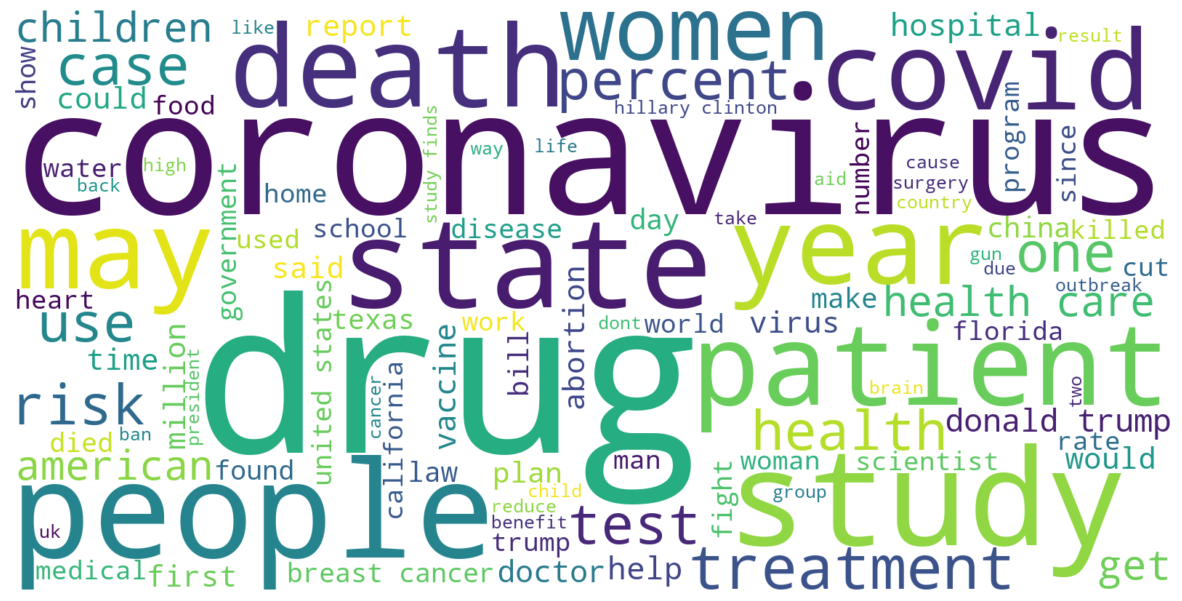

In [43]:
# Visualize the text data in the 'claim' column using a word cloud
data_vis(df_vis, "claim")

/tmp/ipykernel_57310/3623044000.py:65: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




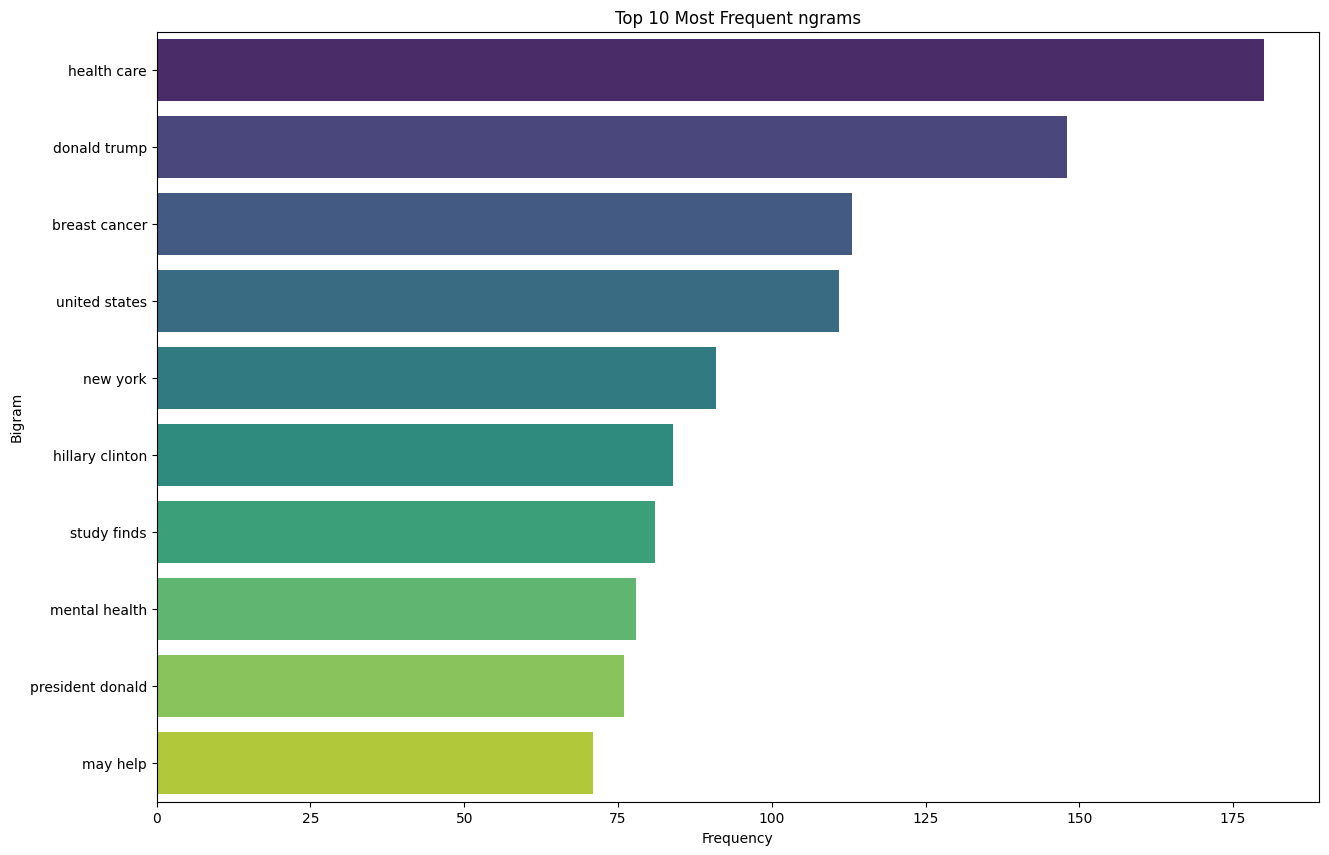

In [44]:
# Create bigrams from the DataFrame
bigram_df = create_bigrams(df_vis)

# Visualize the top 10 most frequent bigrams
visualise_ngram(bigram_df, "Bigram")

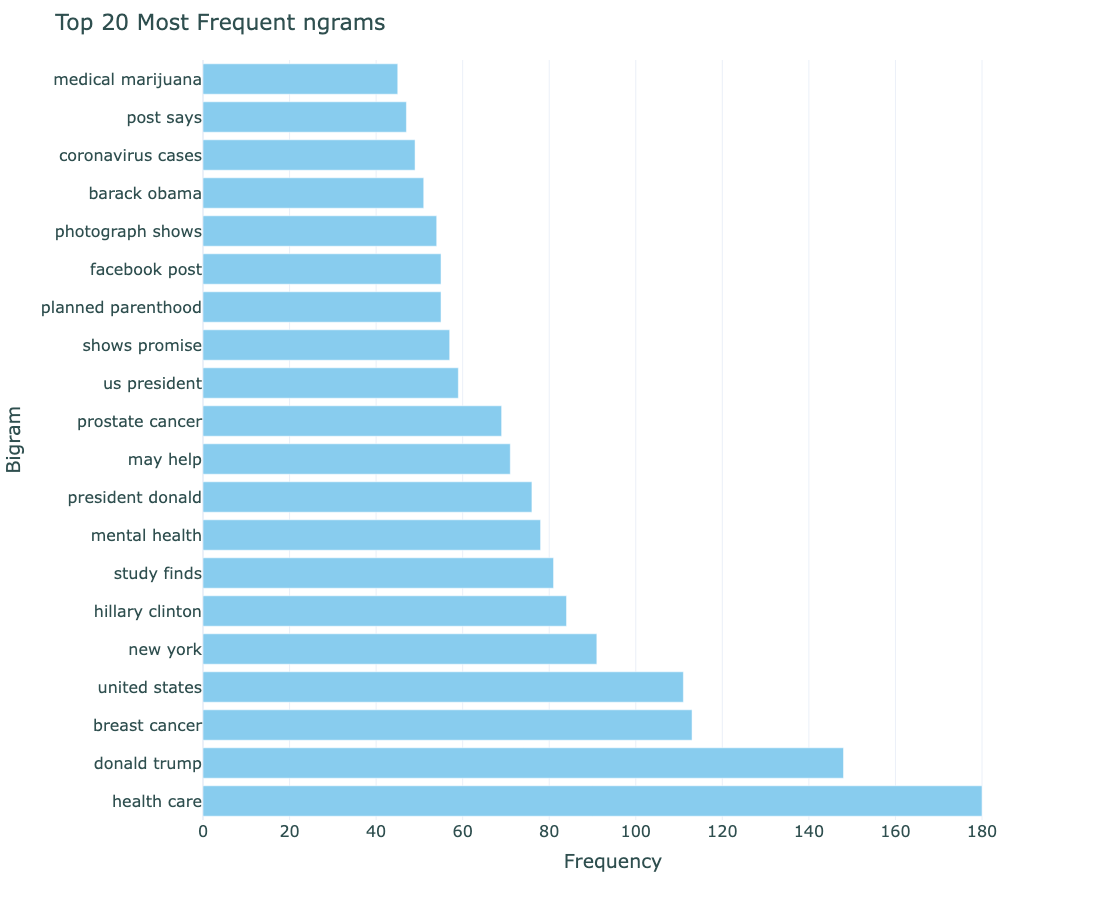

In [45]:
# Plot the top 20 most frequent bigrams using Plotly
ploty_ngram(bigram_df, "Bigram")

/tmp/ipykernel_57310/3623044000.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57310/3623044000.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



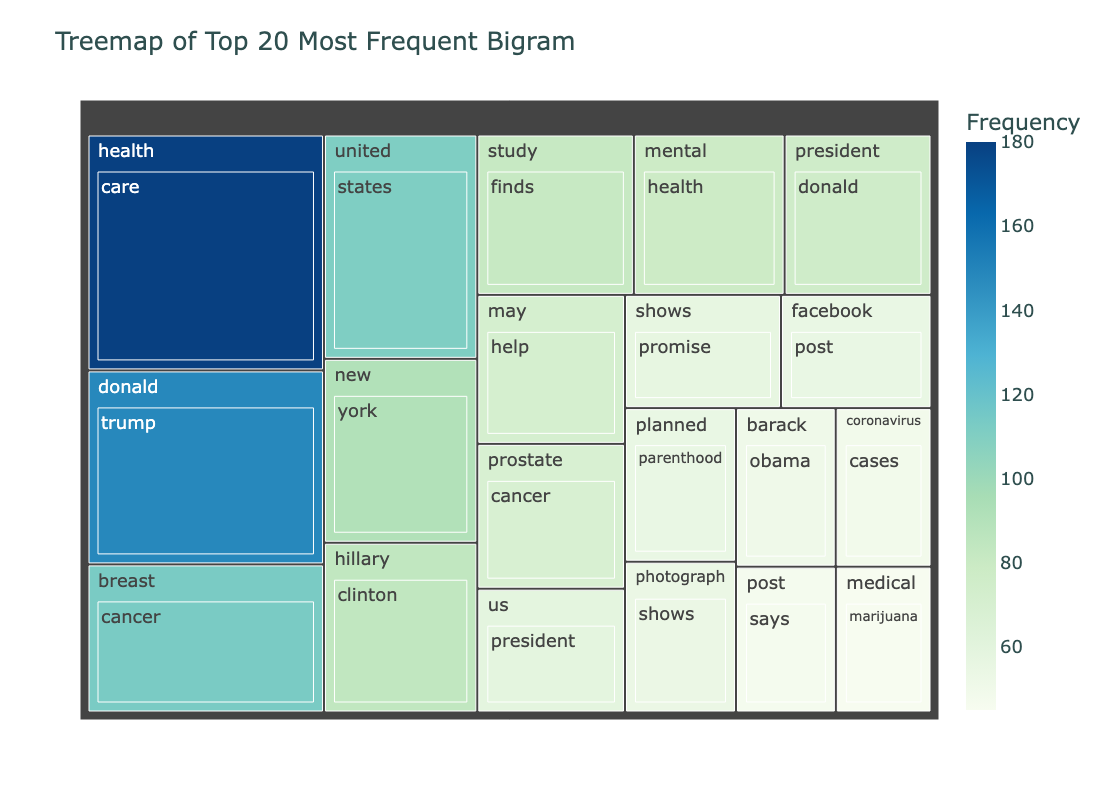

In [46]:
# Plot a treemap of the top 20 most frequent bigrams using Plotly
ploty_treemap(bigram_df, "Bigram")

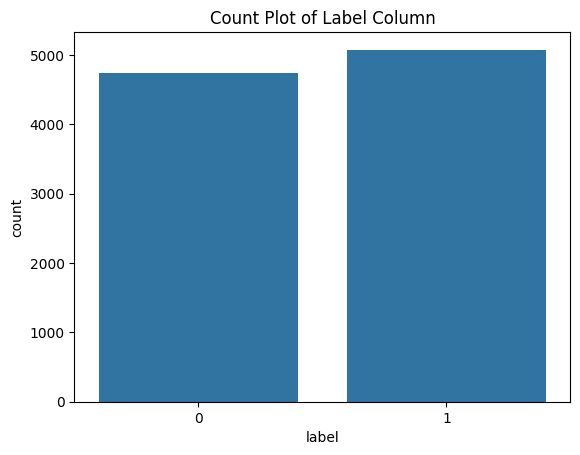

In [47]:
# Generate a count plot for the 'label' column
count_plot(df_vis, "label", "Count Plot of Label Column")

/tmp/ipykernel_57310/3623044000.py:65: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




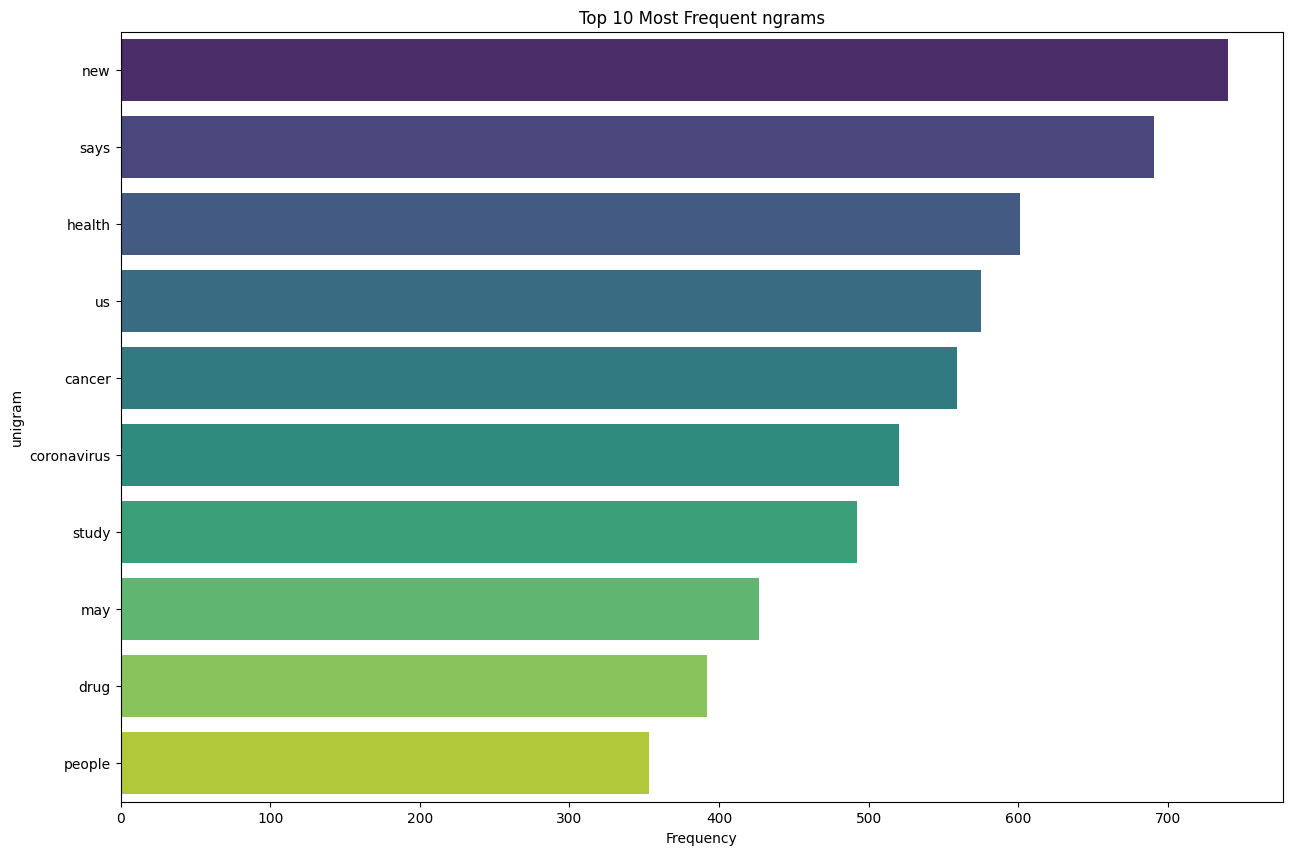

In [48]:
# Create unigrams from the DataFrame
unigram_df = create_unigrams(df_vis)

# Visualize the top 10 most frequent unigrams
visualise_ngram(unigram_df, "unigram")

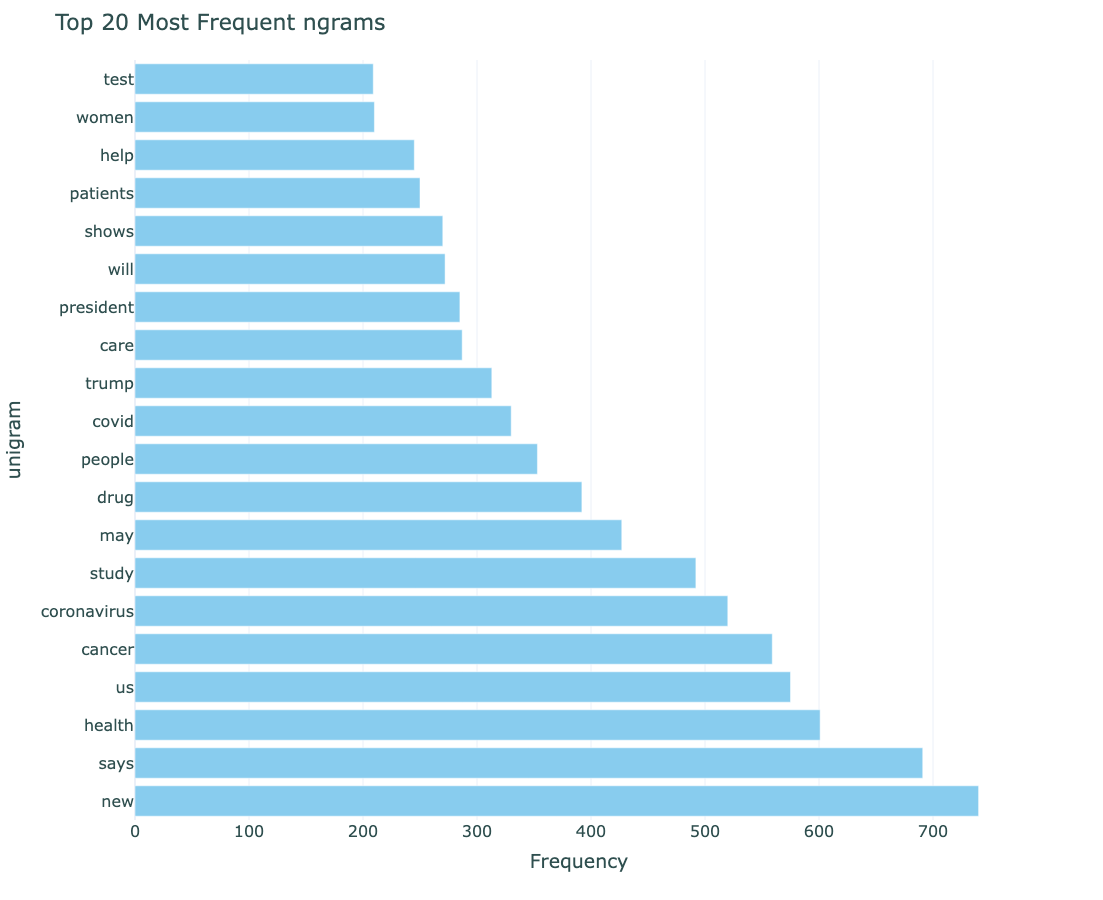

In [49]:
# Plot the top 20 most frequent unigrams using Plotly
ploty_ngram(unigram_df, "unigram")

## Naive Bayes Classifier

In this section, we will implement a Naive Bayes classifier to classify text data. Naive Bayes is a probabilistic classifier that is commonly used for text classification tasks.

### Steps to Implement Naive Bayes Classifier

1. **Data Preprocessing**: Preprocess the text data by tokenizing it, converting it to lowercase, and removing stop words and non-alphabetic characters.

2. **Feature Extraction**: Extract features from the preprocessed text data. This can be done using techniques such as bag-of-words or TF-IDF.

3. **Train-Test Split**: Split the dataset into training and testing sets. The training set will be used to train the Naive Bayes classifier, while the testing set will be used to evaluate its performance.

4. **Model Training**: Train the Naive Bayes classifier using the training set. This involves estimating the probabilities of each class and the conditional probabilities of each feature given each class.

5. **Model Evaluation**: Evaluate the performance of the trained Naive Bayes classifier using the testing set. This can be done by calculating metrics such as accuracy, precision, recall, and F1 score.

6. **Prediction**: Use the trained Naive Bayes classifier to make predictions on new, unseen text data.

### Example Code

Here's an example code snippet that demonstrates how to implement a Naive Bayes classifier using scikit-learn:

```python
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Step 1: Data Preprocessing
# Preprocess the text data by tokenizing it, converting it to lowercase, and removing stop words and non-alphabetic characters.

# Step 2: Feature Extraction
# Extract features from the preprocessed text data using techniques such as bag-of-words or TF-IDF.

# Step 3: Train-Test Split
# Split the dataset into training and testing sets.

# Step 4: Model Training
# Train the Naive Bayes classifier using the training set.

# Step 5: Model Evaluation
# Evaluate the performance of the trained Naive Bayes classifier using the testing set.

# Step 6: Prediction
# Use the trained Naive Bayes classifier to make predictions on new, unseen text data.
```
By following these steps, you can implement a Naive Bayes classifier to classify text data effectively.
```

In [13]:
class NaiveBayesClassifier:
    """
    A Naive Bayes classifier for text classification using TF-IDF vectorization.

    This class implements a text classification pipeline utilizing the Multinomial Naive Bayes algorithm.
    It includes methods for vectorizing text data, performing classification, evaluating the model using
    k-fold cross-validation, and generating performance metrics.

    Attributes:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing the features and target labels.
    feature : pandas.Series
        The feature column from the DataFrame used for training the model.
    target : pandas.Series
        The target column from the DataFrame used for model training and evaluation.
    model : MultinomialNB
        The Naive Bayes model instance used for classification.
    vectorizer : TfidfVectorizer
        The TF-IDF vectorizer used to transform text data into feature vectors.
    X : scipy.sparse.csr_matrix
        The matrix of TF-IDF features for the training data.
    y_pred : numpy.ndarray
        The predicted labels for the test data.
    y_test : numpy.ndarray
        The true labels for the test data.
    """

    def __init__(self, df, feature, target):
        """
        Initializes the classifier with the input DataFrame, the feature column, and the target column.
        """
        self.model = MultinomialNB()
        self.vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
        self.df = df
        self.feature = self.df[feature]
        self.target = self.df[target]

    def vectorize(self):
        """ "
        Transforms the feature text data into TF-IDF vectors.

        Returns:
        --------
        scipy.sparse.csr_matrix
            The matrix of TF-IDF features.
        """
        self.X = self.vectorizer.fit_transform(self.feature)
        return self.X

    def classify(self):
        """ "
        Trains the Naive Bayes classifier and predicts labels for the test set.

        Returns:
        --------
        y_test : pandas.Series
            The true labels for the test set.
        y_pred : numpy.ndarray
            The predicted labels for the test set.
        """
        self.X = self.vectorize()
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.target, test_size=0.2, random_state=42
        )
        self.model.fit(X_train, y_train)
        self.y_pred = self.model.predict(X_test)
        return y_test, self.y_pred

    def kfold_classify(self, n_splits=5):
        """
        Performs k-fold cross-validation to evaluate the model.

        Parameters:
        -----------
        n_splits : int, default=5
            The number of folds for cross-validation.

        Returns:
        --------
        float
            The mean accuracy across all folds.
        numpy.ndarray
            The concatenated true labels from all folds.
        numpy.ndarray
            The concatenated predicted labels from all folds.
        """
        self.X = self.vectorize()
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        accuracies = []
        all_y_test = []
        all_y_pred = []

        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index]
            y_train, y_test = (
                self.target.iloc[train_index],
                self.target.iloc[test_index],
            )
            self.model.fit(X_train, y_train)
            y_pred = self.model.predict(X_test)
            accuracies.append(accuracy_score(y_test, y_pred))
            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)

        self.y_test = np.array(all_y_test)
        self.y_pred = np.array(all_y_pred)
        return np.mean(accuracies), self.y_test, self.y_pred

    def score(self, y_test, y_pred):
        """
        Computes the accuracy of the model.

        Parameters:
        -----------
        y_test : array-like
            The true labels.
        y_pred : array-like
            The predicted labels.

        Returns:
        --------
        float
            The accuracy score.
        """
        return accuracy_score(y_test, y_pred)

    def classification_report(self, y_test, y_pred):
        """
        Generates a detailed classification report including precision, recall, and F1-score.

        Parameters:
        -----------
        y_test : array-like
            The true labels.
        y_pred : array-like
            The predicted labels.

        Returns:
        --------
        str
            The classification report.
        """
        return classification_report(y_test, y_pred)

    def confusion_matrix(self, y_test, y_pred):
        """
        Computes the confusion matrix for the model predictions.

        Parameters:
        -----------
        y_test : array-like
            The true labels.
        y_pred : array-like
            The predicted labels.

        Returns:
        --------
        numpy.ndarray
            The confusion matrix.
        """
        return confusion_matrix(y_test, y_pred)

In [15]:
# Preprocess the data
df = data_preprocess(df)

# Create an instance of the NaiveBayesClassifier class
classifier = NaiveBayesClassifier(df, "main_text", "label")

# Perform classification
y_test, y_pred = classifier.classify()

# Calculate accuracy
accuracy = classifier.score(y_test, y_pred)

# Generate classification report
report = classifier.classification_report(y_test, y_pred)

# Generate confusion matrix
conf_matrix = classifier.confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7852417302798982
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       967
           1       0.81      0.75      0.78       998

    accuracy                           0.79      1965
   macro avg       0.79      0.79      0.79      1965
weighted avg       0.79      0.79      0.79      1965

Confusion Matrix:
 [[793 174]
 [248 750]]


In [16]:
# Perform k-fold cross-validation to evaluate the model
mean_accuracy, y_test, y_pred = classifier.kfold_classify(n_splits=5)

# Print the mean accuracy
print("Mean Accuracy (K-Fold):", mean_accuracy)

# Generate and print the classification report
print(
    "Classification Report (K-Fold):\n",
    classifier.classification_report(y_test, y_pred),
)

# Generate and print the confusion matrix
print("Confusion Matrix (K-Fold):\n", classifier.confusion_matrix(y_test, y_pred))

Mean Accuracy (K-Fold): 0.7717848499453263
Classification Report (K-Fold):
               precision    recall  f1-score   support

           0       0.74      0.81      0.77      4746
           1       0.81      0.73      0.77      5078

    accuracy                           0.77      9824
   macro avg       0.77      0.77      0.77      9824
weighted avg       0.77      0.77      0.77      9824

Confusion Matrix (K-Fold):
 [[3857  889]
 [1353 3725]]


## Bio BERT MODEL

## Functions Overview

### `tokenize_function(batch, target)`
**Purpose:** Tokenizes a batch of text data using a tokenizer.

**Key Steps:**
1. Applies the tokenizer with padding and truncation.
2. Limits token length to a maximum of 128 characters.
3. Returns the tokenized batch.

### `get_tokenized_eval_data(df, target)`
**Purpose:** Prepares the evaluation dataset by tokenizing text data.

**Key Steps:**
1. Preprocesses the DataFrame.
2. Converts DataFrame to a Hugging Face Dataset.
3. Maps the tokenization function over the dataset.
4. Returns tokenized evaluation datasets.

### `compute_metrics(pred)`
**Purpose:** Computes precision, recall, and F1 score for predictions.

**Key Steps:**
1. Loads pre-built metrics for precision, recall, and F1.
2. Uses model logits to generate predictions.
3. Computes precision, recall, and F1 using macro averaging.
4. Returns a dictionary with the computed scores.

### `trainer_model(dataset, output_dir, learning_rate, batch_size, weight_decay)`
**Purpose:** Sets up and trains a model using the Trainer API.

**Key Steps:**
1. Defines training arguments (learning rate, batch size, epochs, etc.).
2. Configures early stopping to prevent overfitting.
3. Creates a Trainer object with the model, dataset, and metrics.
4. Trains the model and returns the trainer object.


In [85]:
# Create a tokenizer using the 'dmis-lab/biobert-base-cased-v1.1' pre-trained model
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = BertForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1"
)


def tokenize_function(batch, target):
    """
    Tokenizes the input batch using the tokenizer.

    Args:
        batch (list): The input batch to be tokenized.
        target (str): The target key in the batch dictionary.

    Returns:
        dict: The tokenized batch.

    """
    return tokenizer(
        batch[target], padding="max_length", truncation=True, max_length=128
    )


def get_tokenized_eval_data(df, target):
    """
    Tokenizes the evaluation data for a fact-checking model.

    Args:
        df (pandas.DataFrame): The input data as a pandas DataFrame.
        target (str): The target column name in the DataFrame.

    Returns:
        eval_tokenized_datasets (Dataset): The tokenized evaluation datasets.

    """
    df = data_preprocess(df)
    eval_dataset = Dataset.from_pandas(df)
    eval_tokenized_datasets = eval_dataset.map(
        tokenize_function, batched=True, fn_kwargs={"target": target}
    )
    return eval_tokenized_datasets


def compute_metrics(pred):
    """
    Compute precision, recall, and F1 score for the given predictions.

    Args:
        pred (tuple): A tuple containing logits and labels.

    Returns:
        dict: A dictionary containing precision, recall, and F1 score.

    """
    metric_precision = load_metric("precision")
    metric_recall = load_metric("recall")
    metric_f1 = load_metric("f1")

    logits, labels = pred
    predictions = logits.argmax(axis=-1)

    precision = metric_precision.compute(
        predictions=predictions, references=labels, average="macro"
    )
    recall = metric_recall.compute(
        predictions=predictions, references=labels, average="macro"
    )
    f1 = metric_f1.compute(predictions=predictions, references=labels, average="macro")

    return {
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }


def trainer_model(dataset, output_dir, learning_rate, batch_size, weight_decay):
    """
    Trains a model using the given dataset.

    Args:
        dataset (Dataset): The training dataset.
        output_dir (str): The directory to save the training results.
        learning_rate (float): The learning rate for the optimizer.
        batch_size (int): The batch size for training and evaluation.
        weight_decay (float): The weight decay for the optimizer.

    Returns:
        Trainer: The trained model trainer.
    """
    training_args = TrainingArguments(
        output_dir=f"./results/{output_dir}",
        eval_strategy="epoch",
        logging_dir=f"./logs/{output_dir}",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=20,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
    )

    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=3,
        early_stopping_threshold=0.01,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping],
    )
    trainer.train()

    return trainer

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
# Load and preprocess the training data
train_df = get_train_data()
train_df = data_preprocess(train_df)
train_dataset = Dataset.from_pandas(train_df)

# Load the evaluation data
eval_df = get_eval_data()

In [87]:
# Tokenize the evaluation dataset
eval_dataset = get_tokenized_eval_data(eval_df, "claim")
tokenized_dataset = train_dataset.map(
    tokenize_function, batched=True, fn_kwargs={"target": "claim"}
)

Map:   0%|          | 0/1235 [00:00<?, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

In [88]:
# Define the grid search parameters
grid_search_params = {
    "batch_size": [16, 32, 64],
    "weight_decay": (0, 0.01, 0.3),
    "learning_rate": (1e-5, 5e-5),
}


def custom_scorer(trainer):
    """
    Custom scorer function that evaluates the performance of a trainer.

    Parameters:
    - trainer: The trainer object to be evaluated.

    Returns:
    - The F1 score obtained from evaluating the trainer.
    """
    metrics = trainer.evaluate()
    return metrics["eval_f1"]


# Wrap the trainer model in a GridSearchCV-compatible class
class HuggingFaceGridSearchCV:
    """
    Grid search cross-validation for Hugging Face models.

    Parameters:
    - param_grid (dict): Dictionary of hyperparameter grids to search over.
    - dataset (str): Path to the dataset.
    - output_dir (str): Path to the output directory.

    Methods:
    - fit(X, y=None): Fit the model using the provided dataset and hyperparameters.
        Returns self.

    Attributes:
    - best_params_ (dict): Best hyperparameters found during the grid search.
    - best_score_ (float): Best score achieved during the grid search.
    """

    def __init__(self, param_grid, dataset, output_dir):
        self.param_grid = param_grid
        self.dataset = dataset
        self.output_dir = output_dir

    def fit(self, X, y=None):
        best_score = -1
        best_params = None
        for lr in self.param_grid["learning_rate"]:
            for bs in self.param_grid["batch_size"]:
                for wd in self.param_grid["weight_decay"]:
                    trainer = trainer_model(self.dataset, self.output_dir, lr, bs, wd)
                    score = custom_scorer(trainer)
                    if score > best_score:
                        best_score = score
                        best_params = {
                            "learning_rate": lr,
                            "batch_size": bs,
                            "weight_decay": wd,
                        }
        self.best_params_ = best_params
        self.best_score_ = best_score
        return self


# Perform grid search
grid_search = HuggingFaceGridSearchCV(
    grid_search_params, tokenized_dataset, output_dir="grid_search_results"
)
grid_search.fit(None)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score achieved: ", grid_search.best_score_)

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.476700,0.477427,0.800531,0.792991,0.793254
2,0.400300,0.434889,0.841038,0.819138,0.818996
3,0.357700,0.463654,0.841183,0.812955,0.812226
4,0.307900,0.546524,0.779980,0.780191,0.779740
5,0.191300,0.726166,0.792582,0.790963,0.791270


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.282100,0.542084,0.794068,0.791507,0.791861
2,0.199900,0.636087,0.803163,0.795398,0.795674
3,0.200600,0.698167,0.810341,0.800853,0.801102
4,0.175500,0.863027,0.778747,0.778822,0.778780


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.125200,1.013081,0.791048,0.786110,0.786426
2,0.146400,0.904639,0.809155,0.793641,0.793379
3,0.177300,0.813262,0.793746,0.789497,0.789850
4,0.161300,1.204370,0.792413,0.786799,0.787096
5,0.087700,1.448105,0.777471,0.775395,0.775691
6,0.069200,1.554608,0.770774,0.771009,0.770777


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.919146,0.773185,0.773416,0.773201
2,0.097300,1.101889,0.783127,0.781092,0.781401
3,0.097300,1.251253,0.794975,0.793419,0.793725
4,0.059100,1.501635,0.778007,0.777744,0.777843


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.502097,0.769210,0.768659,0.768821
2,0.048700,1.186996,0.795753,0.792050,0.792420
3,0.048700,1.454460,0.775054,0.775279,0.774874
4,0.060700,1.527388,0.793574,0.792973,0.793156
5,0.036800,1.759220,0.770774,0.771009,0.770777


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.610434,0.789029,0.786692,0.787026
2,0.027900,1.805882,0.831695,0.808432,0.807928
3,0.027900,1.638525,0.780989,0.779714,0.779976
4,0.049300,1.682640,0.774213,0.774445,0.774060


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.376325,0.768203,0.768252,0.767611
2,No log,1.525469,0.773892,0.774008,0.773937
3,No log,1.633337,0.774101,0.774347,0.774041
4,0.037100,1.630715,0.791980,0.788954,0.789309


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.665991,0.784010,0.783102,0.783328
2,No log,1.660099,0.769488,0.769679,0.769216
3,No log,1.692744,0.781189,0.781132,0.781158
4,0.026600,1.674603,0.792829,0.788711,0.789061


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.931807,0.782370,0.780257,0.780567
2,No log,1.949049,0.796926,0.791759,0.792104
3,No log,1.710505,0.781225,0.781034,0.781111
4,0.022900,1.579772,0.791685,0.789051,0.789400
5,0.022900,1.713065,0.798155,0.793477,0.793844
6,0.022900,1.616927,0.795566,0.793176,0.793529
7,0.023000,1.655187,0.801403,0.794758,0.795076


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.157700,1.018237,0.776325,0.776269,0.776295
2,0.160300,1.123194,0.774476,0.773231,0.773481
3,0.155300,0.952470,0.767759,0.767612,0.766798
4,0.144800,0.992227,0.809864,0.796290,0.796224
5,0.077200,1.207829,0.774101,0.774347,0.774041
6,0.053500,1.273712,0.779394,0.776688,0.774600


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.098800,1.333419,0.779849,0.779122,0.779319
2,0.087900,0.905695,0.769193,0.768098,0.766706
3,0.087700,1.113176,0.820039,0.809695,0.810008
4,0.074600,1.092123,0.787776,0.787421,0.787547
5,0.058000,1.425017,0.766667,0.765050,0.763394


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.083300,1.186777,0.779630,0.779851,0.779667
2,0.060600,1.076222,0.796153,0.792982,0.793353
3,0.070400,1.160087,0.798576,0.793379,0.793735
4,0.062300,1.292764,0.790671,0.789488,0.789754
5,0.049900,1.000368,0.800941,0.795835,0.796208
6,0.036500,1.324390,0.814684,0.804881,0.805162
7,0.027700,1.508680,0.787010,0.787266,0.786989
8,0.031400,1.341955,0.796431,0.789895,0.790177


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.338062,0.787110,0.787363,0.787009
2,0.033000,1.451164,0.775545,0.775571,0.774899
3,0.033000,1.329296,0.801493,0.799902,0.800222
4,0.021200,1.442092,0.782240,0.782151,0.781375


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.263302,0.805370,0.802901,0.803284
2,0.025000,1.264344,0.825116,0.813625,0.813938
3,0.025000,1.725745,0.815999,0.801939,0.801936
4,0.009000,1.369571,0.792140,0.791206,0.791443


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.037172,0.814663,0.807725,0.808139
2,0.027100,1.335616,0.825843,0.801851,0.801108
3,0.027100,1.566258,0.788782,0.786790,0.787110
4,0.014000,1.561135,0.772688,0.771980,0.770802


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.451827,0.807335,0.800406,0.800761
2,No log,1.278489,0.781418,0.780792,0.780973
3,No log,1.312491,0.809665,0.800018,0.800250
4,0.013900,1.213269,0.815099,0.808608,0.809039
5,0.013900,1.253873,0.808441,0.800212,0.800514
6,0.013900,1.448107,0.798997,0.797495,0.797803
7,0.006800,1.571088,0.800732,0.799068,0.799392


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.439885,0.811066,0.798892,0.798962
2,No log,1.296501,0.797434,0.792642,0.793002
3,No log,1.371651,0.794779,0.789254,0.789572
4,0.012300,1.221429,0.790272,0.786304,0.786644
5,0.012300,1.501885,0.790844,0.786158,0.786482
6,0.012300,1.647384,0.799023,0.793282,0.793621
7,0.004200,1.621709,0.798601,0.791419,0.791684


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.665681,0.797698,0.795729,0.796068
2,No log,1.603911,0.774685,0.774736,0.774088
3,No log,1.311804,0.789303,0.789479,0.789358
4,0.008300,1.360918,0.806372,0.793981,0.793960
5,0.008300,1.500388,0.804550,0.797067,0.797372
6,0.008300,1.582489,0.798362,0.793428,0.793790


Best parameters found:  {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0}
Best score achieved:  0.8189960307820183


Lexical based Sentiment Analysis \
Prediction Based Sentiment Analysis


In [89]:
# Train the model using the best hyperparameters from the grid search
trainer = trainer_model(
    tokenized_dataset,
    "results",
    grid_search.best_params_["learning_rate"],
    grid_search.best_params_["batch_size"],
    grid_search.best_params_["weight_decay"],
)

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.003900,1.728443,0.799430,0.796224,0.796607
2,0.004000,1.807978,0.809720,0.800950,0.801235
3,0.002100,1.873427,0.813046,0.801396,0.801534
4,0.001700,2.002551,0.786153,0.785800,0.785925


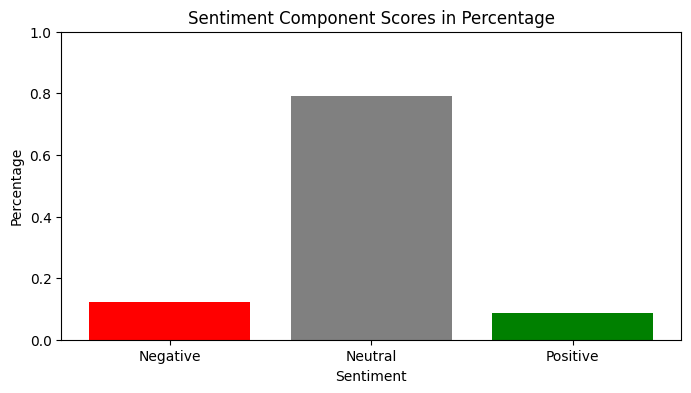

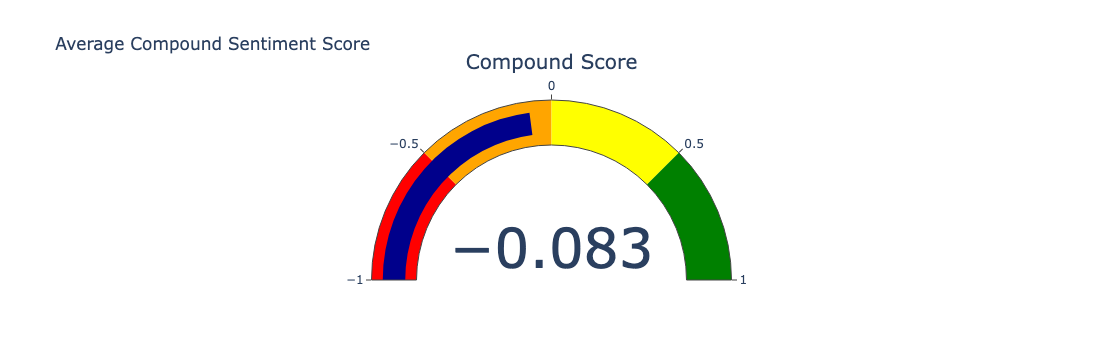

In [126]:
# Create an instance of the SentimentIntensityAnalyzer class
analyzer = SentimentIntensityAnalyzer()


def get_sentiment_score(text):
    """
    Calculates the sentiment score of the given text.

    Parameters:
    text (str): The text for which sentiment score needs to be calculated.

    Returns:
    dict: A dictionary containing the sentiment scores for the text.
    """
    return analyzer.polarity_scores(text)


def get_sentiment_graph(df, column):
    """
    Generates a bar chart and a gauge chart to visualize the sentiment analysis scores of a given DataFrame column.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - column (str): The name of the column in the DataFrame to analyze.

    Returns:
    None
    """
    # Apply the get_sentiment_score function to extract sentiment dictionaries
    sentiment_scores = df[column].apply(get_sentiment_score)

    # Extract individual sentiment components
    components = ["Negative", "Neutral", "Positive"]
    scores = [
        [sentiment["neg"] for sentiment in sentiment_scores],
        [sentiment["neu"] for sentiment in sentiment_scores],
        [sentiment["pos"] for sentiment in sentiment_scores],
    ]

    # Bar chart for individual sentiment components
    plt.figure(figsize=(8, 4))
    plt.bar(
        components,
        [sum(scores[i]) / len(scores[i]) for i in range(len(scores))],
        color=["red", "grey", "green"],
    )
    plt.xlabel("Sentiment")
    plt.ylabel("Percentage")
    plt.title("Sentiment Component Scores in Percentage")
    plt.ylim(0, 1)
    plt.show()

    # Gauge chart for compound score using Plotly
    avg_compound_score = sum(
        [sentiment["compound"] for sentiment in sentiment_scores]
    ) / len(sentiment_scores)

    fig = go.Figure(
        go.Indicator(
            mode="gauge+number",
            value=avg_compound_score,
            title={"text": "Compound Score"},
            gauge={
                "axis": {"range": [-1, 1]},
                "bar": {"color": "darkblue"},
                "steps": [
                    {"range": [-1, -0.5], "color": "red"},
                    {"range": [-0.5, 0], "color": "orange"},
                    {"range": [0, 0.5], "color": "yellow"},
                    {"range": [0.5, 1], "color": "green"},
                ],
            },
        )
    )
    fig.update_layout(title="Average Compound Sentiment Score")
    fig.show()


# Get the training data
df = get_train_data()

# Preprocess the data
df = data_preprocess(df)

# Generate sentiment analysis graph for the 'claim' column
get_sentiment_graph(df, "claim")

# Llama 2 Model
## Functions Overview

### `setup_tokenizer(model_name: str)`
**Purpose:** Set up a tokenizer for a given model name.

**Parameters:**
- `model_name (str)`: The name of the model to use for tokenization.

**Returns:**
- `tokenizer`: The initialized tokenizer object.

### `tokenize(text_list)`
**Purpose:** Tokenizes a list of texts using the BERT tokenizer.

**Parameters:**
- `text_list (list)`: A list of texts to be tokenized.

**Returns:**
- `list`: A list of tokenized texts.

### `get_pipeline(model_name: str, tokenizer)`
**Purpose:** Returns a text generation pipeline using the specified model and tokenizer.

**Parameters:**
- `model_name (str)`: The name of the model to be used.
- `tokenizer`: The tokenizer object.

**Returns:**
- `pipeline`: The text generation pipeline.

### `get_responses(pipeline, queries, max_length: int = 5000, batch_size: int = 8)`
**Purpose:** Generates responses for a given list of queries using a specified pipeline.

**Parameters:**
- `pipeline`: The pipeline used for generating responses.
- `queries`: A list of queries to generate responses for.
- `max_length (int)`: The maximum length of the generated response. Defaults to 5000.
- `batch_size (int)`: The batch size used for generating responses. Defaults to 8.

**Returns:**
- `list`: A list of generated responses for each query.

### `process_claims_batch(claims, prompt_template: str, pipeline: transformers.Pipeline)`
**Purpose:** Process a batch of claims using a given prompt template and a pipeline.

**Parameters:**
- `claims (list)`: A list of claims to be processed.
- `prompt_template (str)`: The template for the prompt to be used with each claim.
- `pipeline (transformers.Pipeline)`: The pipeline to be used for processing the claims.

**Returns:**
- `dict`: A dictionary containing the index of each claim and its corresponding response.

### `get_last_processed_index(output_file: str)`
**Purpose:** Get the index of the last processed entry in the output file.

**Parameters:**
- `output_file (str)`: The path to the output file.

**Returns:**
- `int`: The index of the last processed entry. Returns -1 if the output file does not exist or if there was an error reading the file.

### `process_dataframe_in_batches(df: pd.DataFrame, prompt_template: str, pipeline: transformers.Pipeline, batch_size: int = 8, output_file: str = "output.csv")`
**Purpose:** Process a pandas DataFrame in batches and save the results to a CSV file.

**Parameters:**
- `df (pd.DataFrame)`: The input DataFrame to process.
- `prompt_template (str)`: The template string for generating prompts.
- `pipeline (transformers.Pipeline)`: The pipeline for processing claims.
- `batch_size (int, optional)`: The batch size for processing the DataFrame. Defaults to 8.
- `output_file (str, optional)`: The path to the output CSV file. Defaults to 'output.csv'.

In [52]:
# Define the model name
model_name = "meta-llama/Llama-2-7b-chat-hf"


def setup_tokenizer(model_name: str):
    """
    Set up a tokenizer for a given model name.

    Parameters:
        model_name (str): The name of the model to use for tokenization.

    Returns:
        tokenizer: The initialized tokenizer object.

    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    return tokenizer


def tokenize(text_list):
    """
    Tokenizes a list of texts using the BERT tokenizer.

    Args:
        text_list (list): A list of texts to be tokenized.

    Returns:
        list: A list of tokenized texts.
    """
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    return [tokenizer.tokenize(text) for text in text_list]


def get_pipeline(model_name: str, tokenizer):
    """
    Returns a text generation pipeline using the specified model and tokenizer.

    Args:
        model_name (str): The name of the model to be used.
        tokenizer: The tokenizer object.

    Returns:
        pipeline: The text generation pipeline.
    """
    pipeline = transformers.pipeline(
        "text-generation",
        model=model_name,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        return_full_text=False,
        device="cuda",
    )
    return pipeline


def get_responses(pipeline, queries, max_length: int = 5000, batch_size: int = 8):
    """
    Generates responses for a given list of queries using a specified pipeline.

    Args:
        pipeline: The pipeline used for generating responses.
        queries: A list of queries to generate responses for.
        max_length (int): The maximum length of the generated response. Defaults to 5000.
        batch_size (int): The batch size used for generating responses. Defaults to 8.

    Returns:
        A list of generated responses for each query.
    """
    responses = pipeline(
        queries,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        max_length=max_length,
        truncation=True,
        batch_size=batch_size,
    )
    return [response[0]["generated_text"] for response in responses]


def process_claims_batch(claims, prompt_template: str, pipeline: transformers.Pipeline):
    """
    Process a batch of claims using a given prompt template and a pipeline.

    Args:
        claims (list): A list of claims to be processed.
        prompt_template (str): The template for the prompt to be used with each claim.
        pipeline (transformers.Pipeline): The pipeline to be used for processing the claims.

    Returns:
        dict: A dictionary containing the index of each claim and its corresponding response.
    """
    queries = [
        prompt_template + claim + "[/INST]"
        for claim in claims
        if isinstance(claim, str)
    ]
    responses = get_responses(pipeline, queries)
    return {i: response for i, response in enumerate(responses)}


def get_last_processed_index(output_file: str):
    """
    Get the index of the last processed entry in the output file.

    Args:
        output_file (str): The path to the output file.

    Returns:
        int: The index of the last processed entry. Returns -1 if the output file does not exist or if there was an error reading the file.
    """
    if not os.path.exists(output_file):
        return -1
    try:
        with open(output_file, "r", newline="") as f:
            reader = csv.reader(f)
            next(reader)  # Skip header
            return max((int(row[0]) for row in reader), default=-1)
    except csv.Error as e:
        print(f"Error reading {output_file}: {e}. Starting from the beginning.")
        return -1


def process_dataframe_in_batches(
    df: pd.DataFrame,
    prompt_template: str,
    pipeline: transformers.Pipeline,
    batch_size: int = 8,
    output_file: str = "output.csv",
):
    """
    Process a pandas DataFrame in batches and save the results to a CSV file.
    Args:
        df (pd.DataFrame): The input DataFrame to process.
        prompt_template (str): The template string for generating prompts.
        pipeline (transformers.Pipeline): The pipeline for processing claims.
        batch_size (int, optional): The batch size for processing the DataFrame. Defaults to 8.
        output_file (str, optional): The path to the output CSV file. Defaults to 'output.csv'.
    """
    last_processed_index = get_last_processed_index(output_file)
    start_index = last_processed_index + 1
    total_batches = (len(df) - start_index + batch_size - 1) // batch_size

    file_mode = "a" if start_index > 0 else "w"
    try:
        with open(output_file, file_mode, newline="") as f:
            writer = csv.writer(f, delimiter=",")
            if file_mode == "w":
                writer.writerow(
                    ["index", "response"]
                )  # Write header only if starting from scratch

            for batch_num in range(total_batches):
                start_idx = start_index + batch_num * batch_size
                end_idx = min(start_idx + batch_size, len(df))

                print(f"Processing batch {batch_num + 1}/{total_batches}")

                batch_claims = df["claim"].iloc[start_idx:end_idx].tolist()
                batch_results = process_claims_batch(
                    batch_claims, prompt_template, pipeline
                )

                # Write batch results directly to CSV
                for index, response in batch_results.items():
                    writer.writerow([start_idx + index, response])

                if batch_num % 20 == 0:
                    f.flush()

                print(f"Batch {batch_num + 1} processed and saved to {output_file}")

    except IOError as e:
        print(f"Error saving to {output_file}: {e}")

In [5]:
# Prompt for Llama 2 model
prompt_llama2 = f"""
    <s>[INST] <<SYS>>
    You are an explainable AI model specializing in fact-checking public health claims. 
    You will remove "[INST]" while outputting the answer. You always respond to the latest claim provided.
    Your response should start with "It is" followed by "true" or "false" based on the claim's veracity.
    Provide a concise explanation of why the claim is true or false, using evidence-based reasoning.
    <</SYS>>
    Can you fact-check this for me: {df['claim'][0]}[/INST]
    It is {df['label'][0]}. {df['explanation'][0]}
    </s>
    <s>[INST]
    Can you fact-check this for me:"""

In [140]:
# Set up the tokenizer
tokenizer = setup_tokenizer(model_name)

# Set up the pipeline
pipeline = get_pipeline(model_name, tokenizer)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# Get the training data
df = get_train_data()
# Preprocess the data
df = data_preprocess(df)

In [12]:
# Process the dataframe in batches and save the results to a CSV file
process_dataframe_in_batches(df, prompt_llama2, pipeline)

Processing batch 1/26
Batch 1 processed and saved to output.csv
Processing batch 2/26
Batch 2 processed and saved to output.csv
Processing batch 3/26
Batch 3 processed and saved to output.csv
Processing batch 4/26
Batch 4 processed and saved to output.csv
Processing batch 5/26
Batch 5 processed and saved to output.csv
Processing batch 6/26
Batch 6 processed and saved to output.csv
Processing batch 7/26
Batch 7 processed and saved to output.csv
Processing batch 8/26
Batch 8 processed and saved to output.csv
Processing batch 9/26
Batch 9 processed and saved to output.csv
Processing batch 10/26
Batch 10 processed and saved to output.csv
Processing batch 11/26
Batch 11 processed and saved to output.csv
Processing batch 12/26
Batch 12 processed and saved to output.csv
Processing batch 13/26
Batch 13 processed and saved to output.csv
Processing batch 14/26
Batch 14 processed and saved to output.csv
Processing batch 15/26
Batch 15 processed and saved to output.csv
Processing batch 16/26
Batch

In [27]:
def label_veracity(text):
    """
    Returns the veracity label based on the input text.

    Parameters:
    text (int): The input text to be checked for veracity.

    Returns:
    str: The veracity label, either "true" or "false".
    """
    return "true" if text == 0 else "false"


# Function to tokenize text into list of words while preserving sentences
def tokenize_text(text):
    """
    Tokenizes the given text into sentences and then into words.

    Args:
        text (str): The input text to be tokenized.

    Returns:
        list: A list of tokenized sentences, where each sentence is a list of words.
    """
    # Split text into sentences using a regex
    sentences = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s", text)
    # Tokenize each sentence into words
    tokenized_sentences = [re.findall(r"\b\w+\b", sentence) for sentence in sentences]
    return tokenized_sentences


def compute_multiple_metrics(predictions, references):
    """
    Computes multiple metrics for evaluating the quality of predictions compared to references.

    Args:
        predictions (list): List of predicted sentences.
        references (list): List of reference sentences.

    Returns:
        dict: A dictionary containing the computed metrics.
    """
    metrics = {
        "rouge": load_metric("rouge"),
        "bleu": load_metric("bleu"),
        "bertscore": load_metric("bertscore"),
    }

    results = {}
    for metric_name, metric in metrics.items():
        if metric_name == "bertscore":
            results[metric_name] = metric.compute(
                predictions=predictions, references=references, lang="en"
            )
        elif metric_name == "bleu":
            results[metric_name] = sentence_bleu(
                [sentence.split() for sentence in references],
                predictions,
                (1,),
            )
        else:
            results[metric_name] = metric.compute(
                predictions=predictions, references=references
            )

    return results


def print_results(results):
    """
    Prints the results of a given dictionary containing metric scores.

    Parameters:
    results (dict): A dictionary containing metric scores.

    Returns:
    None
    """
    for metric_name, result in results.items():
        if metric_name == "bertscore":
            print(
                "BERT Score",
                sum(results["bertscore"]["precision"])
                / len(results["bertscore"]["precision"]),
            )
        else:
            print(f"{metric_name.upper()} Score:")
            print(result)
            print()

In [9]:
# Get the training data
df = get_train_data()

# Preprocess the data
df = data_preprocess(df)

# Apply label veracity to the 'label' column
df["label"] = df["label"].apply(label_veracity)

# Create a new column 'label_explanation' combining 'label' and 'explanation'
df["label_explanation"] = (
    "It is " + df["label"].astype(str) + ". " + df["explanation"].astype(str)
)

# Read the response from the CSV file
response = pd.read_csv("output.csv")

# Convert the response to string type
response = response.astype(str)

# Get the references and predictions for computing metrics
references = df["label_explanation"].tolist()
predictions = response["response"].tolist()

In [28]:
# Compute multiple metrics for evaluating the quality of predictions compared to references
results = compute_multiple_metrics(predictions, references)

In [138]:
# Print out the results
print_results(results)

ROUGE Score:
{'rouge1': AggregateScore(low=Score(precision=0.18532307783825136, recall=0.4618138579682497, fmeasure=0.22315235116768717), mid=Score(precision=0.1877486355227056, recall=0.46490071425552537, fmeasure=0.22519544454336526), high=Score(precision=0.1904470774416996, recall=0.4680972187816476, fmeasure=0.22710633584317208)), 'rouge2': AggregateScore(low=Score(precision=0.049555333867747374, recall=0.15036155759012487, fmeasure=0.06321564918098672), mid=Score(precision=0.05043054306105216, recall=0.1527450457149856, fmeasure=0.06415852509021616), high=Score(precision=0.0513227272139633, recall=0.15521825235685507, fmeasure=0.06513654925325732)), 'rougeL': AggregateScore(low=Score(precision=0.11850430440009395, recall=0.3388928553162624, fmeasure=0.14962624803752125), mid=Score(precision=0.11986864915937084, recall=0.34211048332241223, fmeasure=0.15072504785946006), high=Score(precision=0.12135511506378321, recall=0.3455933875502701, fmeasure=0.15183472248552396)), 'rougeLsum':